In [19]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import matplotlib.pyplot as plt
import json

def load_from_disk(name):
    try:
        with open(name, 'r') as f:
            tree = json.load(f)
            return tree
    except:
        return None

# Loading relevant data

In [2]:
lbl2word = load_from_disk("generated/lbl2word.json")
word2lbl = load_from_disk("generated/word2lbl.json")
symbol2name = load_from_disk("generated/symbol2name.json")
name2symbol = load_from_disk("generated/name2symbol.json")

In [3]:
expcheb = pd.read_csv("generated/expcheb.csv")

In [4]:
expcheb.head()

,sName,sSymbol,eligble voters,voters,droped,valid,1,2,3,4,...,Arabs,Founding year,Current type of locality,Organizational affiliation,Coordinates,height,Planning Commission,Police space,year,Cluster Local Authorities
0,Tirosh,10,333,237,2,235,0,6,9,0,...,0.0,1955,310,2.0,1.892863e+09,130.0,151.0,15000597.0,2018,0.0
1,Mevasseret Ziyyon,1015,18871,13883,37,13846,0,2161,557,1,...,98.0,1951,160,0.0,2.144363e+09,583.0,152.0,10002475.0,2018,0.0
2,Me'ir Shefeya,102,106,54,0,54,0,11,4,0,...,38.0,1923,340,0.0,1.975772e+09,63.0,303.0,10004333.0,2018,0.0
3,Or Aqiva,1020,15520,9773,72,9701,0,323,499,0,...,93.0,1951,170,0.0,1.927371e+09,10.0,353.0,10004261.0,2018,0.0
4,Haruzim,1024,584,442,3,439,0,72,13,0,...,0.0,1951,350,0.0,1.874468e+09,39.0,401.0,15000060.0,2018,0.0


In [5]:
expcheb2 = pd.read_csv("generated/expcheb2.csv")

In [6]:
expcheb3 = pd.read_csv("generated/expcheb3.csv")

In [7]:
data = expcheb.append(expcheb2, ignore_index=True)

In [8]:
del expcheb2
del expcheb

# Droping irrelevant columns

droping irrelevant columns like height. We also decided to drop the number of votes and the droped votes because they don't have any relvancy to the the number of valid votes

In [9]:
def drop_cols(data):
    cols = ["sName", "voters", "valid", "droped", "subdistrict", "Natural area", "Metropolitan affiliation", "Founding year", "Organizational affiliation", "Coordinates", "height", "Planning Commission", "Police space", "year", "Cluster Local Authorities"]
    for col in cols:
        data = data.drop(col, axis=1)
        
    return data


In [10]:
train_label = data["valid"]
data = drop_cols(data)
test_label = expcheb3["valid"]
expcheb3 = drop_cols(expcheb3)

In [11]:
RSEED = 50

Running grid search to find the best params for the forest model

In [12]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 150, 200, 250],#The number of trees in the forest.
    'max_depth': [None, 50, 60, 70] ,#The maximum depth of the tree.
    'max_features': ['sqrt', None],#he number of features to consider when looking for the best split
    'min_samples_split': [2, 5, 10],#The minimum number of samples required to split an internal node
    'bootstrap': [True, False]#Whether bootstrap samples are used when building trees.
}

# Estimator for use in random search
estimator = RandomForestRegressor(random_state = RSEED)

# Create the random search model
rs = RandomizedSearchCV(estimator, param_grid, n_jobs = -1, cv = 5, 
                        n_iter = 1, verbose = 1, random_state=RSEED)

# Fit 
rs.fit(data, train_label)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [13]:
rs.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

In [14]:
best_model = rs.best_estimator_

In [15]:
rf_predictions = best_model.predict(expcheb3)
metrics.mean_squared_error(rf_predictions, test_label)

6399061.557509409

In [16]:
cities = ["Haifa", "Sakhnin", "Qazrin", "Elat", "Ayyelet HaShahar"]

In [17]:
df = pd.DataFrame({"Predictions":rf_predictions})
names = [symbol2name[str(value)] for value in expcheb3["sSymbol"]]
df.insert(0,"sName", names)
df.loc[df["sName"].isin(cities)]

,sName,Predictions
59,Ayyelet HaShahar,613.584754
63,Elat,24449.097591
405,Haifa,145724.141492
868,Sakhnin,13020.829905
1033,Qazrin,3892.426218


In [24]:
dd = df.loc[df["sName"].isin(cities)]

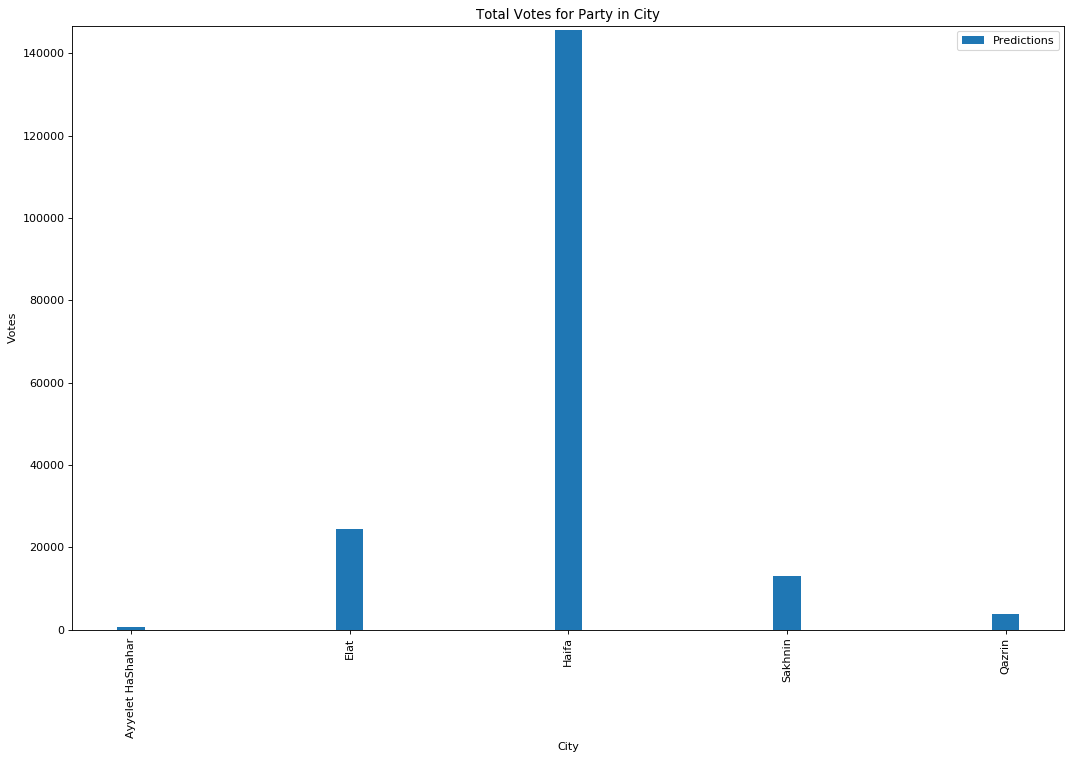

In [26]:
Y1leg = dd["Predictions"]
Xleg = dd.sName
plt.figure(figsize=(16,10), dpi= 80)

plt.bar(Xleg, Y1leg, width= 0.125, label = 'Predictions'  )


gca =  plt.gca()
gca.set_ylim([0, max(dd["Predictions"]) + 1000])
gca.set_xticklabels(Xleg, rotation=90, horizontalalignment= 'center')
plt.title("Total Votes for Party in City")
plt.xlabel('City')
plt.ylabel('Votes')
plt.legend(loc='upper right')
plt.show()